In [16]:
!pip install scikit-learn matplotlib

In [57]:
import warnings
warnings.filterwarnings("ignore")

In [58]:
from sklearn.datasets import make_blobs
import numpy as np
from pyspark.sql.functions import monotonically_increasing_id
from pyspark import SparkFiles
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt

# Create a SparkSession
spark = SparkSession.builder \
    .appName("KmeansClustering") \
    .getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

import pandas as pd
pd.DataFrame.iteritems = pd.DataFrame.items

In [59]:
features, true_labels = make_blobs(
   ...:     n_samples=200,
   ...:     centers=3,
   ...:     cluster_std=2.75,
   ...:     random_state=42
   ...: )

In [60]:
features, true_labels

(array([[ 9.77075874e+00,  3.27621022e+00],
        [-9.71349666e+00,  1.12745180e+01],
        [-6.91330582e+00, -9.34755911e+00],
        [-1.08618591e+01, -1.07506350e+01],
        [-8.50038027e+00, -4.54370383e+00],
        [-4.82456978e+00, -5.20159136e+00],
        [-3.03819028e+00,  9.84354132e+00],
        [-8.17498253e+00, -6.24197227e+00],
        [ 3.91207254e+00,  9.45363489e+00],
        [-4.64425636e+00, -5.14863028e+00],
        [ 2.09082004e+00,  1.80947495e+00],
        [ 5.26539366e+00,  5.56781226e+00],
        [ 7.61826975e+00,  4.87112533e+00],
        [ 3.30512908e+00,  2.19832357e+00],
        [-9.29263277e-01,  2.48591905e+00],
        [-9.15936347e+00, -8.42060745e+00],
        [-2.70722546e+00,  1.17740016e+01],
        [-9.14073328e+00, -6.20996976e+00],
        [ 6.52709436e+00, -2.46179896e+00],
        [-2.51808095e+00, -1.02841022e+01],
        [ 1.04758084e+01,  4.81244915e+00],
        [ 3.33377923e+00,  1.76514294e-01],
        [-5.99215115e+00, -9.154

In [61]:
df1 = spark.createDataFrame(pd.DataFrame(features, columns=['feature1','feature2']))
df1 = df1.withColumn("id1", monotonically_increasing_id())
df2 = spark.createDataFrame(pd.DataFrame(true_labels, columns=['label']))
df2 = df2.withColumn("id1", monotonically_increasing_id())

In [62]:
df = df1.join(df2,on="id1")
df.show(5)

+------------+-------------------+-------------------+-----+
|         id1|           feature1|           feature2|label|
+------------+-------------------+-------------------+-----+
|137438953476| -5.451424276988046| -2.665077582518858|    2|
|146028888066|  5.354556520411266|  4.123182581328336|    1|
|128849018880|  4.765201395963589|0.18126872802473493|    1|
|266287972355|-6.0246313857567575|-2.8228799966646783|    2|
|  8589934592| -3.038190276200837|  9.843541319615756|    0|
+------------+-------------------+-------------------+-----+
only showing top 5 rows



In [63]:
assembler = VectorAssembler(inputCols=["feature1", "feature2"],
                            outputCol="features")
data_df = assembler.transform(df)

# Scale the features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(data_df)
data_df = scaler_model.transform(data_df)
data_df.show(5)

+------------+-------------------+-------------------+-----+--------------------+--------------------+
|         id1|           feature1|           feature2|label|            features|     scaled_features|
+------------+-------------------+-------------------+-----+--------------------+--------------------+
|137438953476| -5.451424276988046| -2.665077582518858|    2|[-5.4514242769880...|[-1.0208417341258...|
|146028888066|  5.354556520411266|  4.123182581328336|    1|[5.35455652041126...|[1.00270213544844...|
|128849018880|  4.765201395963589|0.18126872802473493|    1|[4.76520139596358...|[0.89233862736547...|
|266287972355|-6.0246313857567575|-2.8228799966646783|    2|[-6.0246313857567...|[-1.1281813410243...|
|  8589934592| -3.038190276200837|  9.843541319615756|    0|[-3.0381902762008...|[-0.5689359830702...|
+------------+-------------------+-------------------+-----+--------------------+--------------------+
only showing top 5 rows



In [64]:
kmeans = KMeans(k=3, featuresCol="scaled_features", predictionCol="cluster")
model = kmeans.fit(data_df)

In [65]:
predictions = model.transform(data_df)
predictions.show(5)

+------------+-------------------+-------------------+-----+--------------------+--------------------+-------+
|         id1|           feature1|           feature2|label|            features|     scaled_features|cluster|
+------------+-------------------+-------------------+-----+--------------------+--------------------+-------+
|137438953476| -5.451424276988046| -2.665077582518858|    2|[-5.4514242769880...|[-1.0208417341258...|      1|
|146028888066|  5.354556520411266|  4.123182581328336|    1|[5.35455652041126...|[1.00270213544844...|      2|
|128849018880|  4.765201395963589|0.18126872802473493|    1|[4.76520139596358...|[0.89233862736547...|      2|
|266287972355|-6.0246313857567575|-2.8228799966646783|    2|[-6.0246313857567...|[-1.1281813410243...|      1|
|  8589934592| -3.038190276200837|  9.843541319615756|    0|[-3.0381902762008...|[-0.5689359830702...|      0|
+------------+-------------------+-------------------+-----+--------------------+--------------------+-------+
o

In [66]:
evaluator = ClusteringEvaluator(predictionCol='cluster', featuresCol='scaled_features', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
#evaluator = ClusteringEvaluator()
silhouette_score = evaluator.evaluate(predictions)
print(f"Silhouette Score: {silhouette_score:.4f}")

Silhouette Score: 0.7851


In [67]:
#finding the optimal number of clusters
# Computing WSSSE for K values from 2 to 8
wssse_values =[]
evaluator = ClusteringEvaluator(predictionCol='cluster', featuresCol='scaled_features', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')

for i in range(2,8):    
    KMeans_mod = KMeans(k=i, featuresCol="scaled_features", predictionCol="cluster")  
    KMeans_fit = KMeans_mod.fit(data_df)  
    output = KMeans_fit.transform(data_df)   
    score = evaluator.evaluate(output)   
    wssse_values.append(score)  
    print("Silhouette Score:",score)

Silhouette Score: 0.717867000819364
Silhouette Score: 0.7851032706829334
Silhouette Score: 0.6539854791929076
Silhouette Score: 0.5985964647370021
Silhouette Score: 0.48714964959207163
Silhouette Score: 0.5055882083495703


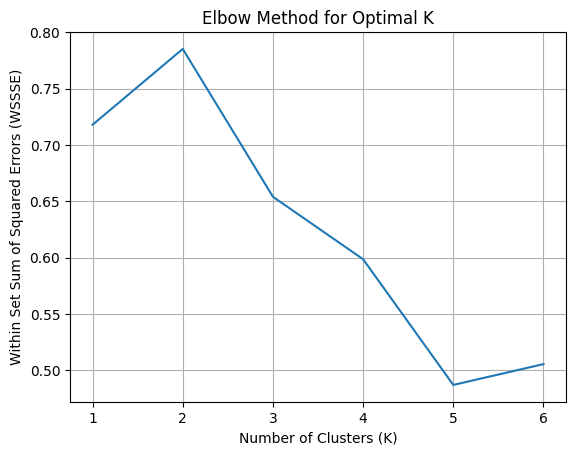

In [68]:
# Plotting WSSSE values
plt.plot(range(1, 7), wssse_values)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within Set Sum of Squared Errors (WSSSE)')
plt.title('Elbow Method for Optimal K')
plt.grid()
plt.show()

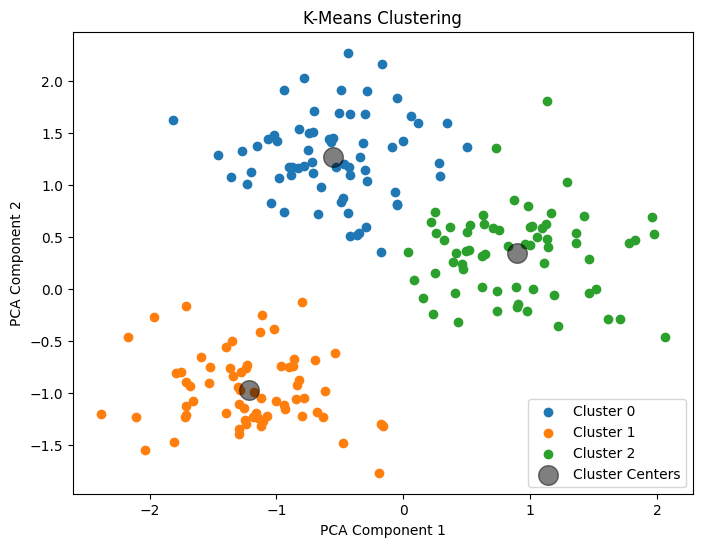

In [69]:
# Visualize the clusters
plt.figure(figsize=(8, 6))
for i in range(3):
    cluster_data = predictions.filter(predictions["cluster"] == i).select("scaled_features").collect()
    cluster_points = [point[0] for point in cluster_data]
    plt.scatter(*zip(*cluster_points), label=f"Cluster {i}")

plt.scatter(*zip(*model.clusterCenters()), c='black', s=200, alpha=0.5, label="Cluster Centers")
plt.title("K-Means Clustering")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()